In [1]:
import numpy as np
import datetime
import pandas as pd

In [2]:
''' Process dataset, extract features. '''

# A dictionary for containing raw features.
features = {}

# Read the data file.
dataset = np.loadtxt(r'dataset/dataset5.log',dtype='str',delimiter=',')

# Get simple features.
features['weather'] = [int(line[1]) for line in dataset[:-1]]
features['wifi_status'] = [int(line[2]) for line in dataset[:-1]]
features['battery'] = [int(line[4]) for line in dataset[:-1]]
features['last_app'] = [line[5] for line in dataset[1:]]
features['earphone'] = [int(line[7]) for line in dataset[:-1]]
features['bluetooth'] = [int(line[8]) for line in dataset[:-1]]
features['next_app'] = [line[6] for line in dataset[1:]]

# Get hour and weekday.
date_time = [datetime.datetime.strptime(line[0],'%Y/%m/%d %H:%M:%S') for line in dataset[:-1]]
features['hour'] = [float(dt.hour)+float(dt.minute)/60 for  dt in date_time]
features['weekday'] = [dt.weekday() for dt in date_time]

# Get last open time.
features['last_open_time'] = []
for counter, la in enumerate(features['last_app']):
    last_open_time = 1296000
    for i in range(counter):
        if features['last_app'][counter-1-i] == la:
            last_open_time = (date_time[counter] - date_time[counter-1-i]).seconds
            break
    features['last_open_time'].append(last_open_time)

# Get  coordinates.
coordinates =  [line[3] for line in dataset[:-1]]
features['longitude'] = []
features['latitude'] = []
for c in coordinates:
    if c in 'unknown' or c in 'null':
        features['longitude'].append(np.nan)
        features['latitude'].append(np.nan)
    else:
        features['longitude'].append(float(c.split('_')[0]))
        features['latitude'].append(float(c.split('_')[1]))


for i in range(1,len(features['last_app'])):
    if features['last_app'][i] == 'null':
        features['last_app'][i] = features['next_app'][i-1]

# Get categories.
app_cat = pd.read_excel('Top2000应用.xlsx')
features['categories'] = []
for a in features['last_app']:
    if a in app_cat.to_dict(orient='list')['包名']:
        features['categories'].append(app_cat['应用分类'][np.where(app_cat['包名'] == a)[0][0]])
    elif 'calculator' in a or 'dialer' in a or 'setting' in a or 'store' in a or 'weather' in a or 'blockchain' in a or 'clock' in a or 'assistant' in a or 'center' in a or 'android' in a:
        features['categories'].append('系统工具')
    elif 'com.meizu.compaign' in a or 'com.meizu.flymelab' in a or 'com.meizu.filemanager' in a or 'com.meizu.notepaper' in a or 'com.meizu.feedback' in a or 'com.meizu.flyme.toolbox' in a or 'com.meizu.mznfcpay' in a or  'com.meizu.safe' in a:
        features['categories'].append('系统工具')
    elif 'media' in a or 'video' in a or 'camera' in a or 'photo' in a or 'tv' in a or 'com.tencent.qqlive.player.meizu' in a:
        features['categories'].append('影音图像')
    elif 'health' in a or 'sport' in a:
        features['categories'].append('运动健康')
    elif 'email' in a or 'message' in a:
        features['categories'].append('通讯社交')
    else:
        features['categories'].append('其他')

# Get frequency.
features['frequency'] = []
apps_freq = {}
for lp in features['last_app']:
    if lp in apps_freq:
        apps_freq[lp] += 1
    elif lp == 'null':
        apps_freq['null'] = np.nan
    else:
        apps_freq[lp] = 1
        
for lp in features['last_app']:
    features['frequency'].append(apps_freq[lp]) 


    
# Get app average used time.
features['use_time'] = []
use_time = {}
for i in range(len(features['last_app'])-1):
    if features['last_app'][i] in use_time:
        use_time[features['last_app'][i]].append((date_time[i+1] - date_time[i]).seconds)
    else:
        use_time[features['last_app'][i]] = [(date_time[i+1] - date_time[i]).seconds]

for ut in use_time:
    use_time[ut] = np.mean(use_time[ut])
    
for lp in features['last_app']:
    features['use_time'].append(use_time[lp])
    

#  Handle missing values.
earphone = [0.5 if e == -1 else e for e in features['earphone']]
features['earphone'] = earphone

bluetooth = [0.5 if b == -1 else b for b in features['bluetooth']]
features['bluetooth'] = bluetooth

wifi = [0.5 if ws == -1 or ws == 2 else ws for ws in features['wifi_status']]
features['wifi_status'] = wifi

frequency = pd.DataFrame(features['frequency'])
frequency.fillna(frequency.median(),inplace=True)
features['frequency'] = frequency[0].tolist()

longitude = pd.DataFrame(features['longitude'])
longitude.fillna(longitude.mean(),inplace=True)
features['longitude'] = longitude[0].tolist()

latitude = pd.DataFrame(features['latitude'])
latitude.fillna(latitude.mean(),inplace=True)
features['latitude'] = latitude[0].tolist()

# Get poi.
''' Using api, translate pois and save them to a text file. '''
features['poi'] = []
# import requests
# keys = ['3d6a65500d61192106d0d9d27ea6953f', '11f9714e1e89c531c8d5c7b1d5fc1d5c', '50b7513606eb24d880340825aa814160', 'f5e156204f7a5012a49c681c9ec4aa5a', 'dfe1fb662ecbb07fb88393b4bae401da']
# for i in range(len(features['longitude'])):
#     long = features['longitude'][i]
#     lat = features['latitude'][i]
#     key = keys[4]
#     r = requests.get('https://restapi.amap.com/v3/geocode/regeo?output=json&location='+
#                      str(long)+','+str(lat)+'&key='+key+'&radius=50&extensions=all')
#     env = np.nan
#     if r.status_code == 200:
#         if len(r.json()['regeocode']['pois']) > 0:
#             env = r.json()['regeocode']['pois'][0]['type']
#     features['poi'].append(str(env))
# np.savetxt('poi/poi6.txt', features['poi'], fmt='%s')

''' Read from text. '''
poi = np.loadtxt('poi/poi5.txt',encoding='utf8',dtype=str)
poi = pd.DataFrame(poi)
features['poi'] = poi[0].tolist()

# Print raw features.
print('\n*************** RAW FEATURES ***************\n')
for f in features:
    print(f, ': \n', features[f][:30], '\n')

''' Process continious values. '''
# Normalization.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_con = np.matrix([features['battery'], features['frequency'], features['longitude'], features['latitude'], features['hour'], features['earphone'], 
                   features['bluetooth'], features['wifi_status'], features['weekday'], features['last_open_time']]).T
X_con = scaler.fit_transform(X_con)


''' Process categorical values. '''
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
lenc = LabelEncoder()
enc = OneHotEncoder()
lb = LabelBinarizer()
features['poi'] = LabelEncoder().fit_transform(features['poi'])
features['categories'] = LabelEncoder().fit_transform(features['categories'])
features['last_app'] = LabelEncoder().fit_transform(features['last_app'])
features['weather'] = LabelEncoder().fit_transform(features['weather'])
# X_cat = np.matrix([features['categories'], features['poi'], features['weather']]).T
# X_cat = enc.fit_transform(X_cat).toarray()
X_cat = np.matrix([features['poi'], features['categories'], features['last_app'], features['weather']]).T
print('X_cat: \n', X_cat)

''' Prepare X. '''
print('\n*************** X MATRIX ***************\n')
print('X_con: ', X_con.shape)
print('X_cat: ', X_cat.shape)
X = np.concatenate((X_con.T,X_cat.T)).T
print('X shape: ', X.shape)
print('X: \n', X)
np.savetxt('X.txt', X, fmt='%s')
''' Select classes to predict. '''
filtered = ['com.flyme.systemuiex', 'com.flyme.roamingpay', 'com.flyme.design', 'com.meizu.powersave', 'jp.co.hit_point.tabikaeru.meizu', 'com.meizu.flyme.xtemui', 'com.meizu.mzsyncservice', 'com.meizu.account',  'com.meizu.perfui', 'com.meizu.flyme.easylauncher', 'com.meizu.mzbasestationsafe', 'com.meizu.battery', 'com.meizu.share']
import queue as Q
pq = Q.PriorityQueue()
for f in apps_freq:
    if f not in filtered:
        pq.put((-apps_freq[f], f))
label = []
for i in range(int(0.2*len(apps_freq))):
    label.append(pq.get()[1]) 

''' Prepare Y. '''
print('\n*************** Y VECTOR ***************\n')

Y = []
options = set()
others_num = 0
for np in features['next_app']:
    if np not in label:
        Y.append('others') 
        others_num += 1
    else:
        Y.append(np)

print('#others: ',others_num)
# np.savetxt('Y.txt', Y, fmt='%s')
with open("Y.txt", "w") as text_file:
    for y in Y:
         text_file.write("%s\n" % y)

for y in Y:
    options.add(y)
print('Y: ', options)

''' Split train and test. '''
print('\n*************** TRAIN AND TEST ***************\n')
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print('training set size: ', X_train.shape[0])
print('test set size: ', X_test.shape[0])





*************** RAW FEATURES ***************

last_app : 
 ['null', 'com.UCMobile', 'com.tencent.mobileqq', 'com.UCMobile', 'com.tencent.mobileqq', 'com.UCMobile', 'com.UCMobile', 'com.tencent.mm', 'com.netease.cloudmusic', 'com.jingdong.app.mall', 'com.meizu.flyme.wallet', 'com.jingdong.app.mall', 'com.android.mms', 'com.jingdong.app.mall', 'com.jingdong.app.mall', 'com.tencent.mm', 'com.jingdong.app.mall', 'com.meizu.flyme.calculator', 'com.jingdong.app.mall', 'com.tencent.mm', 'com.tencent.mobileqq', 'com.UCMobile', 'com.UCMobile', 'com.tencent.mm', 'com.tencent.mm', 'com.tencent.mobileqq', 'com.tencent.mobileqq', 'com.tencent.mm', 'com.tencent.mobileqq', 'com.baidu.tieba'] 

next_app : 
 ['com.UCMobile', 'com.tencent.mobileqq', 'com.UCMobile', 'com.tencent.mobileqq', 'com.UCMobile', 'com.UCMobile', 'com.tencent.mm', 'com.netease.cloudmusic', 'com.jingdong.app.mall', 'com.jingdong.app.mall', 'com.jingdong.app.mall', 'com.android.mms', 'com.jingdong.app.mall', 'com.jingdong.app.mall

In [3]:
''' A function used to evaluate models. '''
def evaluate(Y_pred_proba, classes, Y_test, num=4):
    Y_pred = [[] for i in Y_pred_proba]
    classq = [Q.PriorityQueue() for i in Y_pred_proba]
    for x in range(len(Y_pred_proba)):
        for i in range(len(classes)):
            classq[x].put((-Y_pred_proba[x][i],classes[i]))
        for i in range(num):
            Y_pred[x].append(classq[x].get()[1])
    result = []
    for i in range(len(Y_pred)):
        
        if Y_test[i] in Y_pred[i] and Y_pred[i] != 'others':
            result.append(1)
        else:
            result.append(0)
        
    accuracy = pd.DataFrame(result).mean().item()
    return accuracy

In [4]:
''' A simple function which returns the apps with highest frequencies in the dataset. Used as the benchmark for ML models. '''
def benchmark(Y_test, num=4):
    result = []
        
    for i in range(len(Y_test)):
        if Y_test[i] in label[:num]:
            result.append(1)
        else:
            result.append(0)
    accuracy = pd.DataFrame(result).mean().item()
    return accuracy


*************** CROSS VALIDATION RESULTS FOR MODELS ***************

*Benchmark:  0.735895846249225


/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression:  0.7929324240545568
Random Forest:  0.8226906385616863
SVM:  0.8140111593304402
Gradient Boosting:  0.8307501549907006


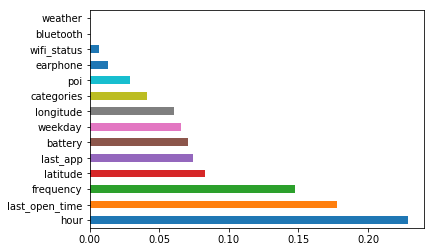

In [5]:
''' Model selection '''
print('\n*************** CROSS VALIDATION RESULTS FOR MODELS ***************\n')

print('*Benchmark: ', benchmark(Y_test))

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1, penalty='l2',multi_class='multinomial',solver='sag')
clf.fit(X_train, Y_train)
Y_pred_proba = clf.predict_proba(X_test)
print('Logistic Regression: ', evaluate(Y_pred_proba, clf.classes_, Y_test))

from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators=300,criterion='entropy', min_samples_leaf=3, n_jobs = -1,random_state=1)
rf = RandomForestClassifier(n_estimators=741, bootstrap=True , criterion='gini', max_depth=None, max_features=5, min_samples_leaf=5,min_samples_split=2, n_jobs = -1,random_state=9)
rf.fit(X_train, Y_train)
Y_pred_proba = rf.predict_proba(X_test)
print('Random Forest: ', evaluate(Y_pred_proba, rf.classes_, Y_test))

from sklearn.svm import SVC
svm = SVC(probability=True,gamma='auto')
svm.fit(X_train, Y_train)
Y_pred_proba = svm.predict_proba(X_test)
print('SVM: ', evaluate(Y_pred_proba, svm.classes_, Y_test))

from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)
Y_pred_proba = gb.predict_proba(X_test)
print('Gradient Boosting: ', evaluate(Y_pred_proba, gb.classes_, Y_test))

import matplotlib.pyplot as plt
%matplotlib inline
feature_names = ['battery', 'frequency', 'longitude', 'latitude', 'hour', 'earphone', 'bluetooth', 'wifi_status', 'weekday', 'last_open_time', 'poi', 'categories', 'last_app', 'weather']
importances = gb.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(14).plot(kind='barh')
plt.show()